# Automated Voigt Species Plots (VSP)

### This code is able to take the component groups and turn it into a csv file that contains all the information about the Veeper fits. It then reduces the pandas data frame to just the fits of the galaxy and runs them through a function that returns the voigt fit and the velocities associated with them to make voigt species plots similar to those seen in Figure 3 of Werk et al. 2013 (https://iopscience.iop.org/article/10.1088/0067-0049/204/2/17/pdf)

Note: This code is meant to be run after the veeper_create-run-collate.ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#plotting things 
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 14

# update various fontsizes to match
params = {'figure.figsize': (18, 12),
          'legend.fontsize': 11,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

import glob
import astropy.units as u
from linetools.spectralline import AbsLine
from linetools.spectra import io as lsio
from linetools.isgm.abscomponent import AbsComponent
from linetools.spectra.xspectrum1d import XSpectrum1D
from linetools.lists.linelist import LineList

#### Information for each Galaxy/QSO LOS: 
- ##### NGC 3489 / J1101: 
    - json_path =  '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101+1429/SamIDs_Nov28_2022.json' 
    - norm = 'J1101+1429_nbin3_jwnorm.fits'
    - Galaxy z: 0.002258
    - QSO z: 0.635
    - V (Helio) [km/s]: 676.9

- ##### NGC 4026 / J1159: 
    - json_path = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159+5106/SamIDs_meth3_Nov28_2022.json'
    - norm = 'J1159+5106_nbin3_jwnorm_meth3.fits'
    - Galaxy z: 0.003286
    - QSO z: 0.524
    - V (Helio) [km/s]: 985.1
    
- ##### NGC 4736 / J1249: 
    - json_path = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249+4122/SamIDs_Nov28_2022.json'
    - norm = 'J1249+4122_nbin3_visit12_jwnorm.fits'
    - Galaxy z: 0.001027
    - QSO z: 0.368
    - V (Helio) [km/s]: 307.8
    
- ##### NGC 3414 / 1051: 
    - json_path = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051+2805/SamIDs_Nov29_2022.json'
    - norm = 'J1051+2805_nbin3_jwnorm.fits'
    - Galaxy z: 0.0049
    - QSO z: 0.423
    - V (Helio) [km/s]: 1469.8
    - all_vp_df.loc[(all_vp_df['zsys'] > 0.002) &  (all_vp_df['zsys'] < 0.005) ]
    - specfile = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051+2805/J1051+2805_nbin3_jwnorm.fits'
    
- ##### NGC 3627 / J1123: 
    - json_path = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1123+1257/SamIDs_Nov29_2022.json'
    - norm = 'J1123+1257_nbin3_BASIC_jwnorm.fits'
    - Galaxy z: 0.00243
    - QSO z: 0.315
    - V (Helio) [km/s]: 721

- ##### NGC 1097 / J0246: 
    - json_path = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J0246-3007/SamIDs_Nov28_2022.json'
    - norm = 'J0246-3007_nbin3_allvisits_jwnorm.fits'
    - Galaxy z: 0.00424
    - QSO z: 0.524
    - V (Helio) [km/s]: 1271.1

- ##### NGC 4564 / J1235: 
    - json_path = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1235+1123/SamIDs_Nov28_2022.json'
    - norm = 'J1235+1123_twovisits_m3_jwnorm.fits'
    - Galaxy z: 0.003809
    - QSO z: 0.949
    - V (Helio) [km/s]: 1141.9

In [2]:
all_vp_df = pd.read_csv('/Users/samgarza/Documents/COS-Holes/veeper_and_voigt/J1051/all_vp.csv')
all_vp_df

,Unnamed: 0,specfile,restwave,zsys,col,sigcol,bval,sigbval,vel,sigvel,...,vlim1,vlim2,wobs1,wobs2,pix1,pix2,z_comp,trans,rely,comment
0,0,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1393.7602,0.00415,13.110,0.068,17.800,4.745,6.094,2.990,...,-52.4764,52.4764,1399.300421,1399.788356,444,458,0.00417,SiIV,c,--
1,1,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1402.7729,0.00415,13.110,0.000,17.800,0.000,6.094,0.000,...,-52.4764,52.4764,1408.348947,1408.840036,691,704,0.00417,SiIV,c,--
2,2,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1393.7602,0.00448,13.504,0.035,35.298,4.077,-9.390,2.637,...,-62.9717,62.9717,1399.714496,1400.300017,456,472,0.00445,SiIV,a,--
3,3,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1402.7729,0.00448,13.504,0.000,35.298,0.000,-9.390,0.000,...,-62.9717,62.9717,1408.765699,1409.355006,702,718,0.00445,SiIV,a,--
4,4,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1526.7070,-0.00009,15.004,0.310,27.331,5.007,0.823,1.671,...,-82.7961,82.7961,1526.154198,1526.997484,3902,3925,-0.00008,SiII,a,--
5,5,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1526.7070,0.00102,14.155,0.047,44.000,6.142,4.518,4.364,...,-67.1769,67.1769,1527.916796,1528.600999,3950,3968,0.00103,SiII,b,--
6,6,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1025.7222,0.41030,14.046,0.027,55.566,4.123,11.260,2.856,...,-93.2914,93.2914,1446.259587,1446.897969,1724,1742,0.41036,H I,c,--
7,7,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1215.6700,0.41030,14.046,0.000,55.566,0.000,11.260,0.000,...,-93.2914,93.2914,1714.084371,1714.840971,9024,9044,0.41036,H I,c,--
8,8,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1025.7222,0.41112,13.672,0.049,20.024,2.997,5.983,2.063,...,-41.9811,41.9811,1447.270480,1447.557752,1752,1760,0.41115,H I,c,--
9,9,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1215.6700,0.41112,13.672,0.000,20.024,0.000,5.983,0.000,...,-41.9811,41.9811,1715.282466,1715.622936,9056,9066,0.41115,H I,c,--


In [3]:
#We care about the absorption features that we see around the galaxy so need to input the correct info for each one 
#Used some galaxy criterion to only see the lines that fit what I want to plot 
gal_df = all_vp_df.loc[(all_vp_df['zsys'] > 0.002) &  (all_vp_df['zsys'] < 0.005) ]#& (all_vp_df['sigcol'] != 0.0)]

gal_df 

,Unnamed: 0,specfile,restwave,zsys,col,sigcol,bval,sigbval,vel,sigvel,...,vlim1,vlim2,wobs1,wobs2,pix1,pix2,z_comp,trans,rely,comment
0,0,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1393.7602,0.00415,13.110,0.068,17.800,4.745,6.094,2.990,...,-52.4764,52.4764,1399.300421,1399.788356,444,458,0.00417,SiIV,c,--
1,1,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1402.7729,0.00415,13.110,0.000,17.800,0.000,6.094,0.000,...,-52.4764,52.4764,1408.348947,1408.840036,691,704,0.00417,SiIV,c,--
2,2,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1393.7602,0.00448,13.504,0.035,35.298,4.077,-9.390,2.637,...,-62.9717,62.9717,1399.714496,1400.300017,456,472,0.00445,SiIV,a,--
3,3,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1402.7729,0.00448,13.504,0.000,35.298,0.000,-9.390,0.000,...,-62.9717,62.9717,1408.765699,1409.355006,702,718,0.00445,SiIV,a,--
10,10,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1526.7070,0.00454,13.709,0.093,20.000,7.358,-11.392,4.647,...,-43.1473,43.1473,1533.419696,1533.859155,4100,4112,0.00450,SiII,c,--
18,18,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1548.2040,0.00442,13.990,0.057,32.780,5.621,6.646,3.813,...,-74.6331,74.6331,1554.656745,1555.427594,4679,4700,0.00444,C IV,a,--
19,19,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1550.7810,0.00442,13.990,0.000,32.780,0.000,6.646,0.000,...,-74.6331,74.6331,1557.244486,1558.016617,4749,4770,0.00444,C IV,a,--


In [4]:
#Pull the parts from gal_df that I want/need for the fitting and plots 

trans = np.array(gal_df['trans'])
zsys = np.array(gal_df['zsys'])
N = np.array(gal_df['col'])
b = np.array(gal_df['bval'])
vel = np.array(gal_df['vel'])
wav = np.array(gal_df['restwave'])

In [5]:
# Define constants

from astropy import constants as const
c = const.c.to('km/s').value #speed of light in km/s for velocity => redshift conversions 

# Load spectrum for plotting
specfile = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051+2805/J1051+2805_nbin3_jwnorm.fits' #normalized spectra file 
xspec = lsio.readspec(specfile)
ism = LineList('ISM')

read_sets: Using set file -- 
  /Users/samgarza/linetools/linetools/lists/sets/llist_v1.3.ascii
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


In [6]:
#Converts wavelengths to velocities 
def convert_wave2vel(obs_wave, rest_wave, LSR_vel=0.):
    # Define constants
    c = const.c.to('km/s').value #has the right value but no units 
    return (((obs_wave - rest_wave)/rest_wave) * c) - LSR_vel #calculates z then * c to makes velocity

#Function to make the bulk of the species plots 
def voigt_species(redshift, column_density, b_value, restwavelen): 
    # Set line attributes 
    N = 10**(column_density)/u.km**2  # Column density => Not sure on the units of this 
    b = b_value*u.km/u.s      # Doppler b parameter => Not sure on the units of this => 
    z = redshift            # redshift of absorption feature
    restwav = restwavelen*u.Angstrom

    absline = AbsLine(restwav)  # Initialize AbsLine object
    absline.attrib['N'] = N
    absline.attrib['b'] = b
    absline.setz(z)
    
    # Generate model voigt profiles

    wv_array = xspec.wavelength # Use wavelength array from the spectrum you loaded

    voigt = absline.generate_voigt(wave=wv_array)
    
    vels = convert_wave2vel(wv_array, restwav, LSR_vel=1469.8) #This LSR_vel changes for each galaxy/QSO LOS 
    
    return voigt, vels

In [7]:
#This is the actually automated part and this makes life so much easier 
Voigt = []
Vels = []

for i in range(len(trans)): 
    vo, ve = voigt_species(zsys[i], N[i], b[i], wav[i])
    Voigt.append(vo)
    Vels.append(ve)

Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


/Users/samgarza/linetools/linetools/analysis/voigt.py:187: UserWarning: Using a sub-grid wavelength array because the input array is too coarse.
  warnings.warn('Using a sub-grid wavelength array because the input array is too coarse.')
/Users/samgarza/linetools/linetools/analysis/voigt.py:188: UserWarning: Will return values rebinned to the input array.
  warnings.warn('Will return values rebinned to the input array.')
/Users/samgarza/linetools/linetools/analysis/voigt.py:244: UserWarning: Assuming infinite spectral resolution, i.e. no smoothing.
  warnings.warn('Assuming infinite spectral resolution, i.e. no smoothing.')
/Users/samgarza/linetools/linetools/analysis/voigt.py:245: UserWarning: Set fwhm to smooth.
  warnings.warn('Set fwhm to smooth.')


Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


In [10]:
Vels

[<Quantity [-3784.2776315 , -3776.38575362, -3768.49387575, ...,
            75994.71579661, 76002.60767448, 76010.49955236]>,
 <Quantity [-5695.54908083, -5687.70790762, -5679.86673441, ...,
            73570.87090501, 73578.71207822, 73586.55325143]>,
 <Quantity [-3784.2776315 , -3776.38575362, -3768.49387575, ...,
            75994.71579661, 76002.60767448, 76010.49955236]>,
 <Quantity [-5695.54908083, -5687.70790762, -5679.86673441, ...,
            73570.87090501, 73578.71207822, 73586.55325143]>,
 <Quantity [-29688.88510396, -29681.68045678, -29674.47580959, ...,
             43142.89325047,  43150.09789766,  43157.30254484]>,
 <Quantity [-33459.71426933, -33452.60965955, -33445.50504976, ...,
             38360.78602402,  38367.8906338 ,  38374.99524358]>,
 <Quantity [-33904.73336306, -33897.64055931, -33890.54775557, ...,
             37796.41969218,  37803.51249593,  37810.60529967]>]

In [11]:
Voigt

[<XSpectrum1D: file=none, nspec=1, select=0, wvmin=1383 Angstrom, wvmax=1753.97 Angstrom>,
 <XSpectrum1D: file=none, nspec=1, select=0, wvmin=1383 Angstrom, wvmax=1753.97 Angstrom>,
 <XSpectrum1D: file=none, nspec=1, select=0, wvmin=1383 Angstrom, wvmax=1753.97 Angstrom>,
 <XSpectrum1D: file=none, nspec=1, select=0, wvmin=1383 Angstrom, wvmax=1753.97 Angstrom>,
 <XSpectrum1D: file=none, nspec=1, select=0, wvmin=1383 Angstrom, wvmax=1753.97 Angstrom>,
 <XSpectrum1D: file=none, nspec=1, select=0, wvmin=1383 Angstrom, wvmax=1753.97 Angstrom>,
 <XSpectrum1D: file=none, nspec=1, select=0, wvmin=1383 Angstrom, wvmax=1753.97 Angstrom>]

In [9]:
#labels for each feature
labels = []
for i in range(len(trans)): 
    #Transition, wavelength, redshift, column density, impact parameter
    labels.append((trans[i], wav[i], zsys[i], N[i], b[i]))
    
labels

[('SiIV', 1393.7602, 0.00415, 13.11, 17.8),
 ('SiIV', 1402.7729, 0.00415, 13.11, 17.8),
 ('SiIV', 1393.7602, 0.00448, 13.504, 35.298),
 ('SiIV', 1402.7729, 0.00448, 13.504, 35.298),
 ('SiII', 1526.707, 0.00454, 13.709, 20.0),
 ('C IV', 1548.204, 0.00442, 13.99, 32.78),
 ('C IV', 1550.781, 0.00442, 13.99, 32.78)]

In [16]:
#Want to make each plotting part a function? 

def J1051_vsp(): 
    #This is the least automated part of the work but can make minor adjustments since the rest of this is so automated 
    fig, axs = plt.subplots(3,2)
    fig.suptitle('NGC 3414 Voigt Species Plots', fontsize=30)

    #CIV 1548 (5)
    axs[0,0].step(Vels[5], xspec.flux/xspec.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[0,0].plot(Vels[5]+vel[5], Voigt[5].flux, c='red', lw=3, label = labels[5] )  
    axs[0,0].plot(Vels[5], xspec.sig/xspec.co, c='red', ls=':') #error
    axs[0,0].axvline(0, c='dimgray', ls=':')
    axs[0,0].set_xlim(-300,300)
    axs[0,0].set_ylim(0,1.2)
    axs[0,0].set_title('Galaxy: z = 0.0049, b = 40.499, log$M_{*}$ = 10.8, log$M_{BH}$ = 8.40', fontsize=15)
    axs[0,0].legend(loc=4)

    #CIV 1550 (6)
    axs[1,0].step(Vels[6], xspec.flux/xspec.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[1,0].plot(Vels[6]+vel[6], Voigt[6].flux, c='red', lw=3, label = labels[6] ) 
    axs[1,0].plot(Vels[6], xspec.sig/xspec.co, c='red', ls=':') #error
    axs[1,0].axvline(0, c='dimgray', ls=':')
    axs[1,0].set_xlim(-300,300)
    axs[1,0].set_ylim(0,1.2)
    axs[1,0].legend(loc=4)

    #SiII 1526 (4)
    axs[2,0].step(Vels[4], xspec.flux/xspec.co, c='darkgray')          # Plot continuum-normalized spectrum
    axs[2,0].plot(Vels[4]+vel[4], Voigt[4].flux, c='olivedrab', lw=3, label = labels[4] )  
    axs[2,0].plot(Vels[4], xspec.sig/xspec.co, c='red', ls=':') #error 
    axs[2,0].axvline(0, c='dimgray', ls=':')
    axs[2,0].set_xlim(-300,300)
    axs[2,0].set_ylim(0,1.2)
    axs[2,0].set_xlabel('Relative Velocity [km/s]')
    axs[2,0].legend(loc=4)

    #SiIV 1393 (0 and 2)
    axs[0,1].step(Vels[0], xspec.flux/xspec.co, c='darkgray')          # Plot continuum-normalized spectrum
    axs[0,1].plot(Vels[0]+vel[0], Voigt[0].flux, c='blue', lw=3, label = labels[0]) 
    axs[0,1].plot(Vels[2]+vel[2], Voigt[2].flux, c='blueviolet', lw=3, label = labels[2])
    axs[0,1].plot(Vels[0], xspec.sig/xspec.co, c='red', ls=':') #error 
    axs[0,1].axvline(0, c='dimgray', ls=':')
    axs[0,1].set_xlim(-300,300)
    axs[0,1].set_ylim(0,1.2)
    axs[0,1].set_title('QSO: J1051+2805, z = 0.423', fontsize=15)
    axs[0,1].legend(loc=4)

    #SiIV 1402 (1 and 3)
    axs[1,1].step(Vels[1], xspec.flux/xspec.co, c='darkgray')          # Plot continuum-normalized spectrum
    axs[1,1].plot(Vels[1]+vel[1], Voigt[1].flux, c='blue', lw=3, label = labels[1] ) 
    axs[1,1].plot(Vels[3]+vel[3], Voigt[3].flux, c='blueviolet', lw=3, label = labels[3] )
    axs[1,1].plot(Vels[1], xspec.sig/xspec.co, c='red', ls=':') #error 
    axs[1,1].axvline(0, c='dimgray', ls=':')
    axs[1,1].set_xlim(-300,300)
    axs[1,1].set_ylim(0,1.2)
    axs[1,1].set_xlabel('Relative Velocity [km/s]')
    axs[1,1].legend(loc=4)

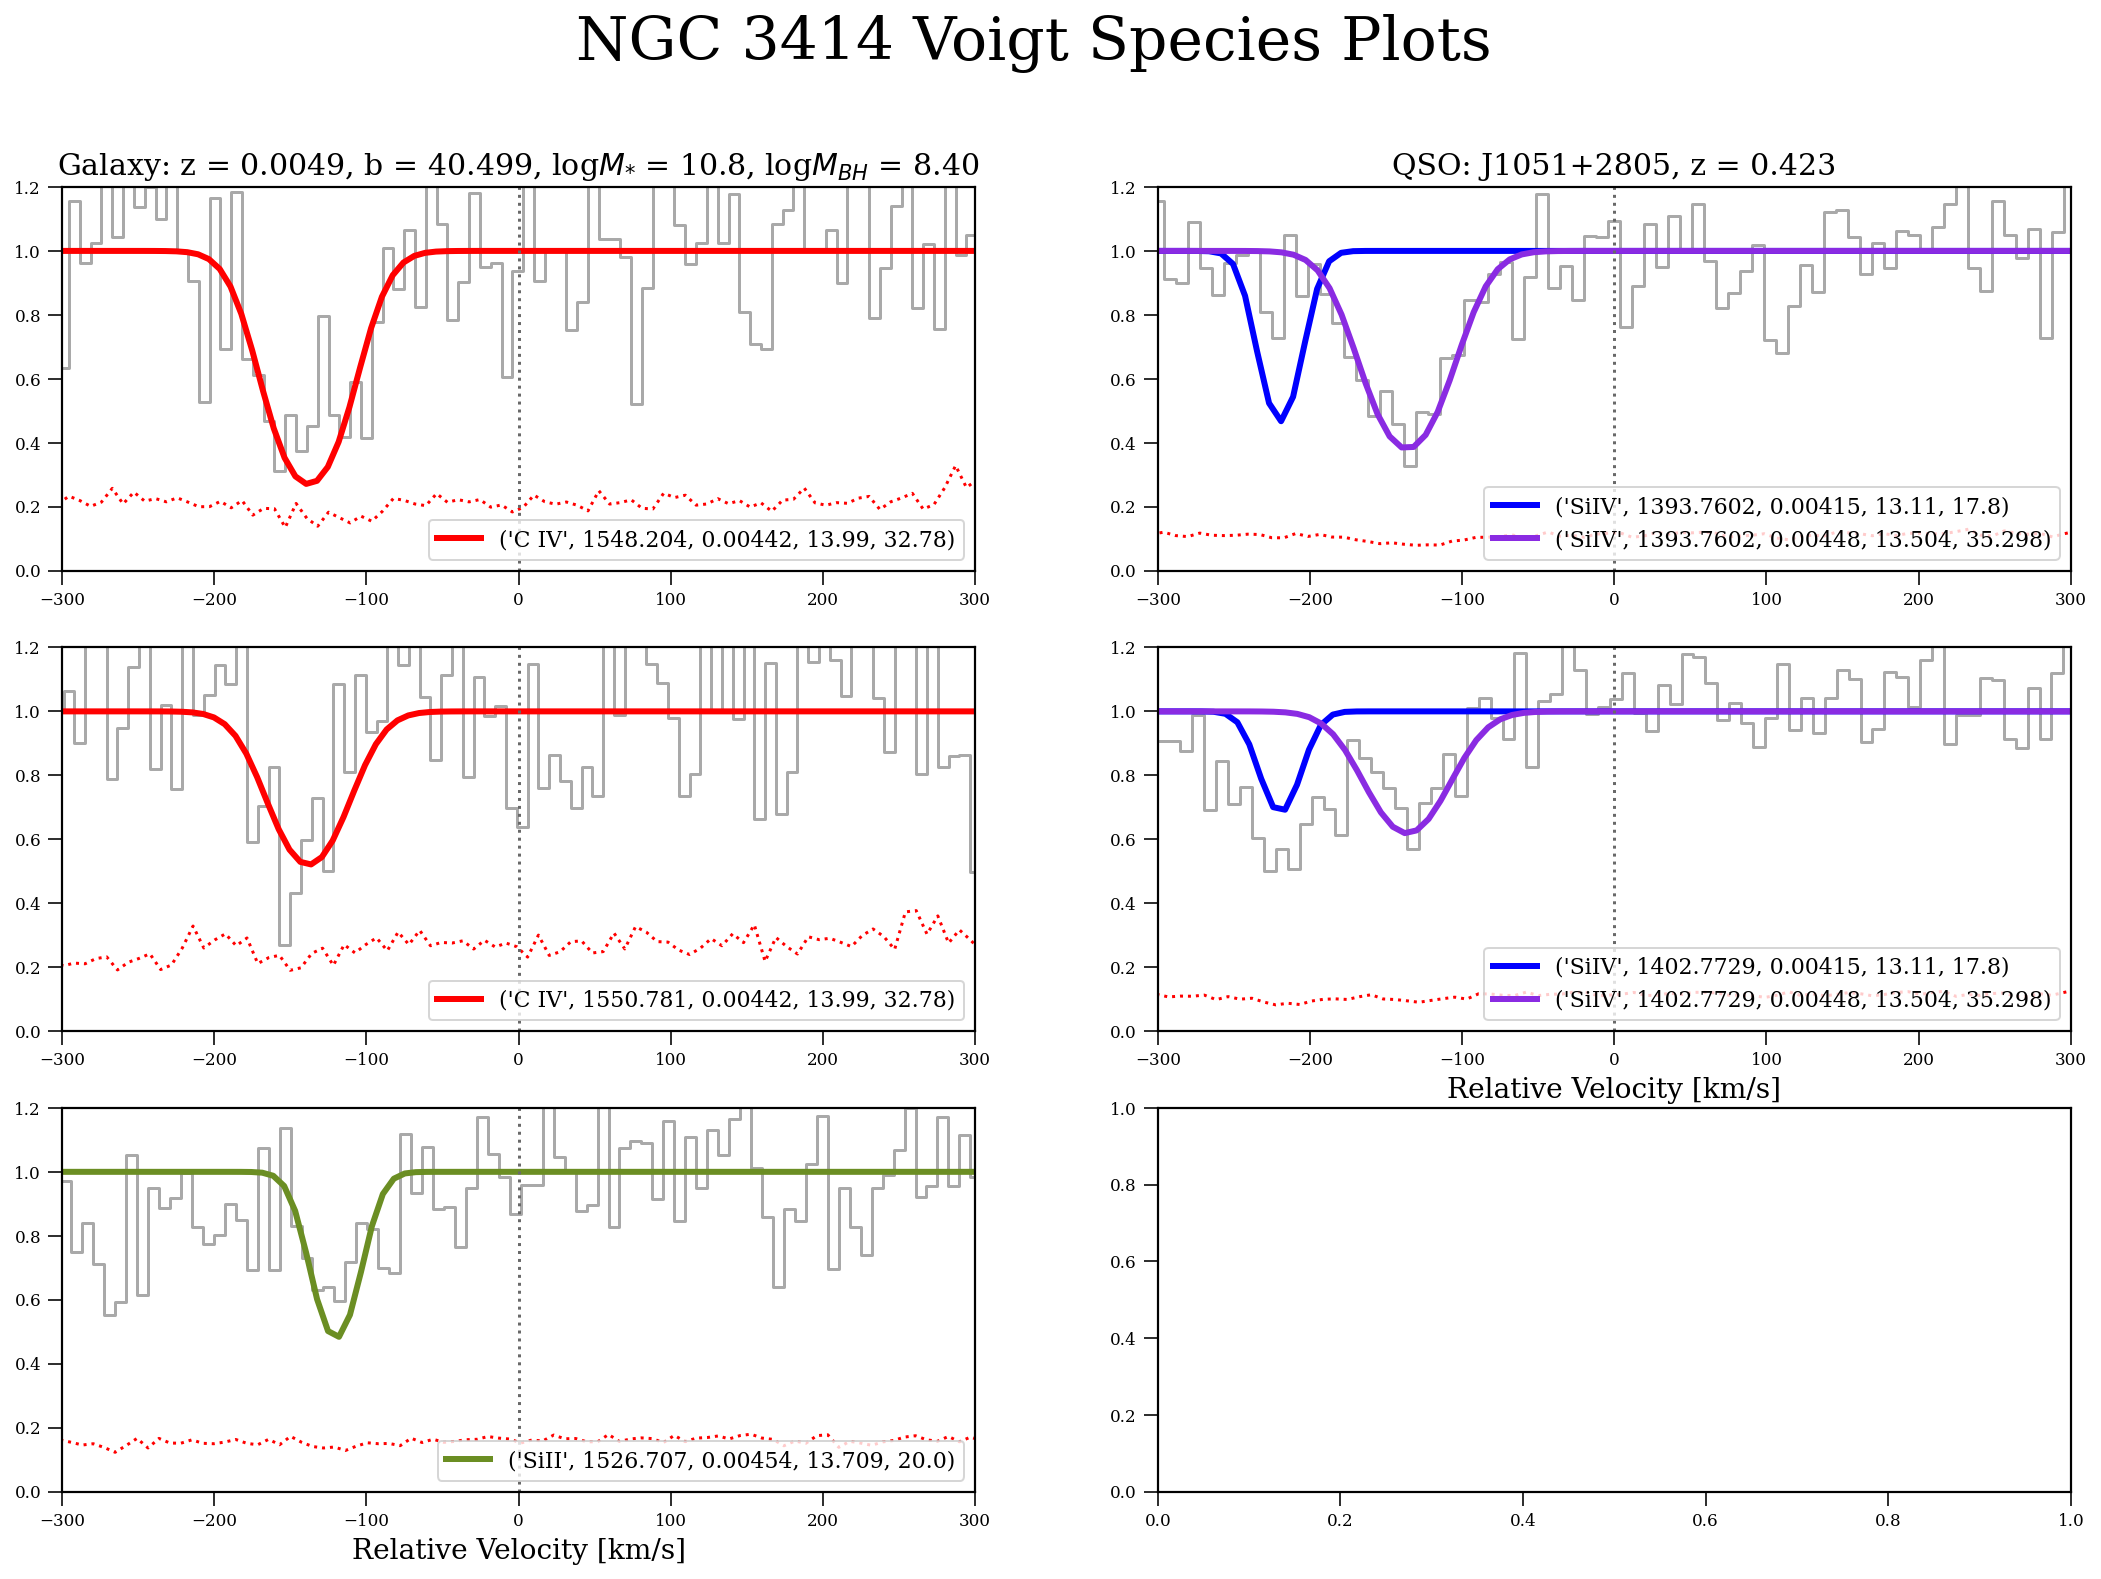

In [17]:
J1051_vsp()